# Load WiC dataset

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("path_to_WiC", sep='\t',header=None)
data.columns = ['keyword', 'POS', 'indices', 'sentence1', 'sentence2']

In [3]:
data.head()

,keyword,POS,indices,sentence1,sentence2
0,carry,V,2-1,You must carry your camping gear .,Sound carries well over water .
1,go,V,2-6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?
2,break,V,0-2,Break an alibi .,The wholesaler broke the container loads into ...
3,cup,N,8-4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .
4,academy,N,1-2,The Academy of Music .,The French Academy .


In [4]:
data.shape

(5428, 5)

In [5]:
gold_labels = pd.read_csv("path_to_gold_labels", sep = '\t', header=None)
gold_labels.columns=['human_label']
gold_labels.head()

,human_label
0,F
1,F
2,F
3,T
4,F


In [6]:
data = data.set_index(data.index).join(gold_labels.set_index(gold_labels.index))
data.head()

,keyword,POS,indices,sentence1,sentence2,human_label
0,carry,V,2-1,You must carry your camping gear .,Sound carries well over water .,F
1,go,V,2-6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,F
2,break,V,0-2,Break an alibi .,The wholesaler broke the container loads into ...,F
3,cup,N,8-4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,T
4,academy,N,1-2,The Academy of Music .,The French Academy .,F


# Load pre-trained BERT

In [7]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to('cuda')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import tagset_mapping, map_tag
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import numpy as np
from sklearn.decomposition import PCA
import random
import warnings
warnings.filterwarnings("ignore") 

In [9]:
# function to create word embedding
def emb(text, target_index):
    tokens = text.lower().split(' ')
    tokenized_words = []
    emb_index = []
    tokenized_words.append('[CLS]')
    for word_sim in tokens:
        len_now = 0
        for tokenized in tokenizer.tokenize(word_sim):
            len_now+=1
            tokenized_words.append(tokenized)
        emb_index.append([len(tokenized_words) -1 - i for i in range(len_now)])
    tokenized_words.append('[SEP]')
    #print(tokenized_words) #########################################################
    #print(emb_index) #########################################################
    
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_words)
    # Mark each of the 22 tokens as belonging to sentence "1".
    segments_ids = [1] * len(tokenized_words)
    # Convert inputs to PyTorch tensors
    
    #tokens_tensor = torch.tensor([indexed_tokens]).to('cuda')
    #segments_tensors = torch.tensor([segments_ids]).to('cuda')
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        encoded_layers, _ = model(tokens_tensor, segments_tensors)
    return sum([encoded_layers[11][0][temp_index].to('cpu') for temp_index in emb_index[target_index]])/len(emb_index[target_index])

# Default BERT prediction

In [10]:
# record the default prediction
default = []
for index in range(len(data)):
    text1 = data.iloc[index]['sentence1']
    target_index1 = int(data.iloc[index]['indices'].split('-')[0])
    text2 = data.iloc[index]['sentence2']
    target_index2 = int(data.iloc[index]['indices'].split('-')[1])
    emb1 = emb(text1, target_index1)
    emb2 = emb(text2, target_index2)
    cos = torch.cosine_similarity(emb1.reshape(1,-1), emb2.reshape(1,-1))[0].item()
    if cos >= 0.5:
        default.append('T')
    else:
        default.append('F')


In [11]:
data['default'] = pd.Series(default)
data.head()

,keyword,POS,indices,sentence1,sentence2,human_label,default
0,carry,V,2-1,You must carry your camping gear .,Sound carries well over water .,F,F
1,go,V,2-6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,F,T
2,break,V,0-2,Break an alibi .,The wholesaler broke the container loads into ...,F,F
3,cup,N,8-4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,T,T
4,academy,N,1-2,The Academy of Music .,The French Academy .,F,T


In [36]:
# default acc
score=0
for index in range(len(data)):
    if data.iloc[index]['human_label'] == data.iloc[index]['default']:
        score+=1
print(score/len(data))

0.6862564480471629


In [12]:
# add word frequency to data
import joblib
record = joblib.load('path_to_record_dictionary')
# key = (word, word type i.e. VERB, stop or non-stop word), value = [frequency]
len(record)

1003229

In [49]:
[(k,v) for (k,v) in record.items() if k[0]=='negotiate']

[(('negotiate', 'VERB', 'NON_STOP'), [3094]),
 (('negotiate', 'NOUN', 'NON_STOP'), [188]),
 (('negotiate', 'ADJ', 'NON_STOP'), [102]),
 (('negotiate', 'ADV', 'NON_STOP'), [16]),
 (('negotiate', 'ADP', 'NON_STOP'), [7]),
 (('negotiate', 'DET', 'NON_STOP'), [1])]

In [13]:
# record the word frequency and log-2 frequency
freq=[]
log2freq=[]
for index in range(len(data)):
    word = data.iloc[index]['keyword']
    if data.iloc[index]['POS'] == 'V':
        pos = 'VERB'
    else:
        pos = 'NOUN'
    if word in gensim.parsing.preprocessing.STOPWORDS:
        stop = 'STOP'
    else:
        stop = 'NON_STOP'
    if (word, pos, stop) in record.keys(): 
        freq.append(record[(word, pos, stop)][0])
        log2freq.append(np.log2(record[(word, pos, stop)][0]))
    else:
        if (word, stop) in [(k[0], k[2]) for (k,v) in record.items()]:
            temp = [v for (k,v) in record.items() if k[0]==word and k[2]==stop]
            if len(temp) ==1:
                freq.append(temp[0][0])
                log2freq.append(np.log2(temp[0][0]))
            else:
                print('not found', word)
                freq.append('not found')
                log2freq.append('not found')
        else:
            print('not found', word)
            freq.append('not found')
            log2freq.append('not found')

not found commercialization
not found ulteriority
not found hyponym
not found ulteriority
not found ulteriority
not found negociate
not found hyponym
not found shtik
not found commercialization
not found etiolation
not found hyponym
not found summerize
not found misplay
not found commercialization


In [14]:
data['freq'] = pd.Series(freq)
data['log2freq'] = pd.Series(log2freq)
data.head()

,keyword,POS,indices,sentence1,sentence2,human_label,default,freq,log2freq
0,carry,V,2-1,You must carry your camping gear .,Sound carries well over water .,F,F,51781,15.660135
1,go,V,2-6,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,F,T,1425686,20.443225
2,break,V,0-2,Break an alibi .,The wholesaler broke the container loads into ...,F,F,92773,16.501417
3,cup,N,8-4,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,T,T,59218,15.853748
4,academy,N,1-2,The Academy of Music .,The French Academy .,F,T,8268,13.013323


In [15]:
data = data.drop(data[data['freq'] == 'not found'].index)
len(data)

5414

In [16]:
data=data.reset_index()
data.index

RangeIndex(start=0, stop=5414, step=1)

In [17]:
# default acc
score=0
for index in range(len(data)):
    if data.iloc[index]['human_label'] == data.iloc[index]['default']:
        score+=1
print(score/len(data))

0.6859992611747322


In [18]:
data.to_csv('WIC_default_freq_V1.csv')

In [ ]:
# record the word embedding
emb_1 = []
emb_2 = []
for index in range(len(data)):
    text1 = data.iloc[index]['sentence1']
    target_index1 = int(data.iloc[index]['indices'].split('-')[0])
    text2 = data.iloc[index]['sentence2']
    target_index2 = int(data.iloc[index]['indices'].split('-')[1])
    emb1 = emb(text1, target_index1)
    emb2 = emb(text2, target_index2)
    emb_1.append(emb1)
    emb_2.append(emb2)

In [ ]:
data['emb1'] = pd.Series(emb_1)
data['emb2'] = pd.Series(emb_2)
data.to_csv('WIC_default_V3_emb.csv')

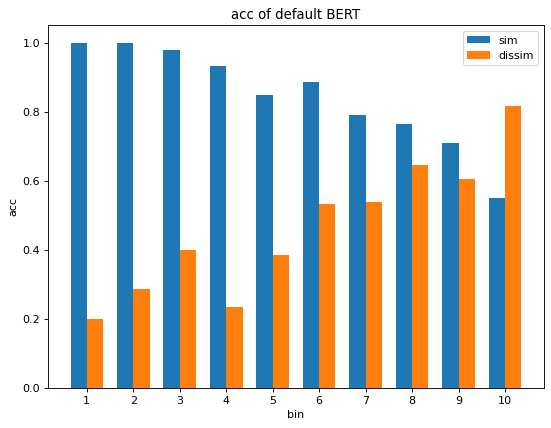

In [31]:
# default BERT prediction
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
freq = [np.log2(i[1][0]) for i in sorted(record.items(), key=lambda x:-x[1][0]) if i[0][2]=='NON_STOP' and i[0][1] in ['NOUN','VERB']]
no_bin = 10
move = max(freq)/no_bin
x=[j for j in range(1,11)]
y_sim=[]
y_dissim=[]
for index in range(no_bin):
    left = index*move
    if index == no_bin-1:
        right = max(freq)+1
    else:
        right = (index+1)*move
    F = data[(data['human_label'] == 'F') & (data['log2freq']>= left) & (data['log2freq']< right)]
    T = data[(data['human_label'] == 'T') & (data['log2freq']>= left) & (data['log2freq']< right)]
    F_F = F[F['default']=='F']
    T_T = T[T['default']=='T']
    y_dissim.append(len(F_F)/len(F))
    y_sim.append(len(T_T)/len(T))
    #print(len(T), len(T_T))

figure(figsize=(8, 6), dpi=80)
N = 10

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, y_sim, width, label='sim')
plt.bar(ind + width, y_dissim, width,
    label='dissim')

plt.ylabel('acc')
plt.xlabel('bin')
plt.title('acc of default BERT')

plt.xticks(ind + width / 2, x)
plt.legend(loc='best')
plt.show()